## Meter Reading

<img src='https://user-images.githubusercontent.com/71766106/229337163-9b679eca-3fdc-4c76-bb86-9dede5458420.png' width=50%>

In [ ]:
!pip install ultralytics

In [24]:
import tensorflow as tf
from ultralytics import YOLO
import os
from pathlib import Path as path
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [3]:
# download detector and segmentor weights
!gdown 167NnyQ3hxNbxzs9qNs0f5ekDtvIePy0s
!gdown 1ZvDzcEqIt7NNzUTcr0kmccu6h58CLBGs

Downloading...
From: https://drive.google.com/uc?id=167NnyQ3hxNbxzs9qNs0f5ekDtvIePy0s
To: /content/train_model.h5
100% 391M/391M [00:04<00:00, 86.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ZvDzcEqIt7NNzUTcr0kmccu6h58CLBGs
To: /content/best.pt
100% 6.20M/6.20M [00:00<00:00, 38.0MB/s]


### Downloading Paddle's meter Dataset

In [ ]:
det = 'https://bj.bcebos.com/paddlex/examples/meter_reader/datasets/meter_det.tar.gz'
seg = 'https://bj.bcebos.com/paddlex/examples/meter_reader/datasets/meter_seg.tar.gz'
test = 'https://bj.bcebos.com/paddlex/examples/meter_reader/datasets/meter_test.tar.gz'

if ('meter_seg' not in os.listdir()):
    for i in [det,seg,test]:
        !wget $i
        dir_name = i.split('/')[-1]
        !tar -xf $dir_name
else:
    print('Directory already exist')

### Defining Utility Functions

In [2]:
# ALL THE FUNCTIONS DEFINED IN THIS CELL ARE FROM OpenVINO's 203-meter-reader.ipynb

METER_SHAPE = [256, 256] 
CIRCLE_CENTER = [128, 128] 
CIRCLE_RADIUS = 125
PI = math.pi
RECTANGLE_HEIGHT = 60
RECTANGLE_WIDTH = 785
TYPE_THRESHOLD = 40

METER_CONFIG = [{
    'scale_interval_value': 25.0 / 50.0,
    'range': 25.0,
    'unit': "(MPa)"
}, {
    'scale_interval_value': 1.6 / 32.0,
    'range': 1.6,
    'unit': "(MPa)"
}]

SEG_LABEL = {'background': 0, 'pointer': 1, 'scale': 2}

def roi_crop(image, results, scale_x, scale_y):
    """
    Crop the area of detected meter of original image

    Param：
        img (np.array)：original image。
        det_results (list[dict]): detection results
        scale_x (float): the scale value in x axis
        scale_y (float): the scale value in y axis

    Retuns：
        roi_imgs (list[np.array]): the list of meter images
        loc (list[int]): the list of meter locations
    
    """
    roi_imgs = []
    loc = []
    for result in results:
        bbox = result
        xmin, ymin, xmax, ymax = [int(bbox[0] * scale_x), int(bbox[1] * scale_y), int(bbox[2] * scale_x), int(bbox[3] * scale_y)]
        sub_img = image[ymin:(ymax + 1), xmin:(xmax + 1), :]
        roi_imgs.append(sub_img)
        loc.append([xmin, ymin, xmax, ymax])
    return roi_imgs, loc

def roi_process(input_images, target_size, interp=cv2.INTER_LINEAR):
    """
    Prepare the roi image of detection results data
    Preprocessing the input data for segmentation task

    Param：
        input_images (list[np.array])：the list of meter images
        target_size (list|tuple)： height and width of resized image， e.g [heigh,width]
        interp (int)：the interp method for image reszing

    Retuns：
        img_list (list[np.array])：the list of processed images
        resize_img (list[np.array]): for visualization
    
    """
    img_list = list()
    resize_list = list()
    for img in input_images:
        img_shape = img.shape
        scale_x = float(target_size[1]) / float(img_shape[1])
        scale_y = float(target_size[0]) / float(img_shape[0])
        resize_img = cv2.resize(img, None, None, fx=scale_x, fy=scale_y, interpolation=interp)
        resize_list.append(resize_img)
        resize_img = resize_img.transpose(2, 0, 1) / 255
        img_mean = np.array([0.5, 0.5, 0.5]).reshape((3, 1, 1))
        img_std = np.array([0.5, 0.5, 0.5]).reshape((3, 1, 1))
        resize_img -= img_mean
        resize_img /= img_std
        img_list.append(resize_img)
    return img_list, resize_list


def erode(seg_results, erode_kernel):
    """
    Erode the segmentation result to get the more clear instance of pointer and scale

    Param：
        seg_results (list[dict])：segmentation results
        erode_kernel (int): size of erode_kernel

    Return：
        eroded_results (list[dict])： the lab map of eroded_results
        
    """
    kernel = np.ones((erode_kernel, erode_kernel), np.uint8)
    eroded_results = seg_results
    for i in range(len(seg_results)):
        eroded_results[i] = cv2.erode(seg_results[i].astype(np.uint8), kernel)
    return eroded_results


def circle_to_rectangle(seg_results):
    """
    Switch the shape of label_map from circle to rectangle

    Param：
        seg_results (list[dict])：segmentation results

    Return：
        rectangle_meters (list[np.array])：the rectangle of label map

    """
    rectangle_meters = list()
    for i, seg_result in enumerate(seg_results):
        label_map = seg_result

        # The size of rectangle_meter is determined by RECTANGLE_HEIGHT and RECTANGLE_WIDTH
        rectangle_meter = np.zeros((RECTANGLE_HEIGHT, RECTANGLE_WIDTH), dtype=np.uint8)
        for row in range(RECTANGLE_HEIGHT):
            for col in range(RECTANGLE_WIDTH):
                theta = PI * 2 * (col + 1) / RECTANGLE_WIDTH
                
                # The radius of meter circle will be mapped to the height of rectangle image
                rho = CIRCLE_RADIUS - row - 1
                y = int(CIRCLE_CENTER[0] + rho * math.cos(theta) + 0.5)
                x = int(CIRCLE_CENTER[1] - rho * math.sin(theta) + 0.5)
                rectangle_meter[row, col] = label_map[y, x]
        rectangle_meters.append(rectangle_meter)
    return rectangle_meters


def rectangle_to_line(rectangle_meters):
    """
    Switch the dimension of rectangle label map from 2D to 1D

    Param：
        rectangle_meters (list[np.array])：2D rectangle OF label_map。

    Return：
        line_scales (list[np.array])： the list of scales value
        line_pointers (list[np.array])：the list of pointers value

    """
    line_scales = list()
    line_pointers = list()
    for rectangle_meter in rectangle_meters:
        height, width = rectangle_meter.shape[0:2]
        line_scale = np.zeros((width), dtype=np.uint8)
        line_pointer = np.zeros((width), dtype=np.uint8)
        for col in range(width):
            for row in range(height):
                if rectangle_meter[row, col] == SEG_LABEL['pointer']:
                    line_pointer[col] += 1
                elif rectangle_meter[row, col] == SEG_LABEL['scale']:
                    line_scale[col] += 1
        line_scales.append(line_scale)
        line_pointers.append(line_pointer)
    return line_scales, line_pointers


def mean_binarization(data_list):
    """
    Binarize the data

    Param：
        data_list (list[np.array])：input data

    Return：
        binaried_data_list (list[np.array])：output data。

    """
    batch_size = len(data_list)
    binaried_data_list = data_list
    for i in range(batch_size):
        mean_data = np.mean(data_list[i])
        width = data_list[i].shape[0]
        for col in range(width):
            if data_list[i][col] < mean_data:
                binaried_data_list[i][col] = 0
            else:
                binaried_data_list[i][col] = 1
    return binaried_data_list


def locate_scale(line_scales):
    """
    Find location of center of each scale

    Param：
        line_scales (list[np.array])：the list of binaried scales value

    Return：
        scale_locations (list[list])：location of each scale

    """
    batch_size = len(line_scales)
    scale_locations = list()
    for i in range(batch_size):
        line_scale = line_scales[i]
        width = line_scale.shape[0]
        find_start = False
        one_scale_start = 0
        one_scale_end = 0
        locations = list()
        for j in range(width - 1):
            if line_scale[j] > 0 and line_scale[j + 1] > 0:
                if not find_start:
                    one_scale_start = j
                    find_start = True
            if find_start:
                if line_scale[j] == 0 and line_scale[j + 1] == 0:
                    one_scale_end = j - 1
                    one_scale_location = (one_scale_start + one_scale_end) / 2
                    locations.append(one_scale_location)
                    one_scale_start = 0
                    one_scale_end = 0
                    find_start = False
        scale_locations.append(locations)
    return scale_locations


def locate_pointer(line_pointers):
    """
    Find location of center of pointer

    Param：
        line_scales (list[np.array])：the list of binaried pointer value

    Return：
        scale_locations (list[list])：location of pointer

    """
    batch_size = len(line_pointers)
    pointer_locations = list()
    for i in range(batch_size):
        line_pointer = line_pointers[i]
        find_start = False
        pointer_start = 0
        pointer_end = 0
        location = 0
        width = line_pointer.shape[0]
        for j in range(width - 1):
            if line_pointer[j] > 0 and line_pointer[j + 1] > 0:
                if not find_start:
                    pointer_start = j
                    find_start = True
            if find_start:
                if line_pointer[j] == 0 and line_pointer[j + 1] == 0 :
                    pointer_end = j - 1
                    location = (pointer_start + pointer_end) / 2
                    find_start = False
                    break
        pointer_locations.append(location)
    return pointer_locations


def get_relative_location(scale_locations, pointer_locations):
    """
    Match location of pointer and scales

    Param：
        scale_locations (list[list])：location of each scale
        pointer_locations (list[list])：location of pointer

    Return：
        pointed_scales (list[dict])： a list of dict with:
                                     'num_scales': total number of scales
                                     'pointed_scale': predicted number of scales
            
    """
    pointed_scales = list()
    for scale_location, pointer_location in zip(scale_locations,
                                                pointer_locations):
        num_scales = len(scale_location)
        pointed_scale = -1
        if num_scales > 0:
            for i in range(num_scales - 1):
                if scale_location[i] <= pointer_location < scale_location[i + 1]:
                    pointed_scale = i + (pointer_location - scale_location[i]) / (scale_location[i + 1] - scale_location[i] + 1e-05) + 1
        result = {'num_scales': num_scales, 'pointed_scale': pointed_scale}
        pointed_scales.append(result)
    return pointed_scales


def calculate_reading(pointed_scales):
    """
    Calculate the value of meter according to the type of meter

    Param：
        pointed_scales (list[list])：predicted number of scales

    Return：
        readings (list[float])： the list of values read from meter
            
    """
    readings = list()
    batch_size = len(pointed_scales)
    for i in range(batch_size):
        pointed_scale = pointed_scales[i]
        # find the type of meter according the total number of scales
        if pointed_scale['num_scales'] > TYPE_THRESHOLD:
            reading = pointed_scale['pointed_scale'] * METER_CONFIG[0]['scale_interval_value']
        else:
            reading = pointed_scale['pointed_scale'] * METER_CONFIG[1]['scale_interval_value']
        readings.append(reading)
    return readings

### Loading Model

In [3]:
# Loading trained model {Traning is showed in segmentor.ipynb and detector.ipynb}

detector = YOLO('best.pt')  # best.pt are weights of YOLO8

segmentor = tf.keras.models.load_model('train_model.h5') # H5 file is U-NET with Resnet50 backbone

In [41]:
def plot_result(img,readings,bboxs):
    '''
    Parameters
        img (np.ndarray) : image
        readings (array) : reading of detected meters
        bboxs(np.ndarray): BBOXs of detected meters
    
    Returns
        img (np.ndarray) : image with BBOX and readings
    '''
    for i in range(len(readings)):
        reading = readings[i]
        if reading >= 0:
            xmin,ymin,xmax,ymax = list(np.array(bboxs[i]).astype(np.int32))

            img = cv2.rectangle(img,
                                (xmin,ymin),
                                (xmax,ymax),
                                (255, 51, 204),
                                3)
            img = cv2.putText(img,
                            f'{reading:.3f}',
                            (xmin,ymin),
                            cv2.FONT_HERSHEY_SIMPLEX,
                            1,
                            (255,0,255),
                            4)
    return img

In [42]:
def pipeline(frame):
    '''
    Complete pipeline

    Image --> Detection --> Cropping --> Semantic-Segmentation --> Reading --> Plotting
    '''


    # Getting Detection BBOXs
    prediction = detector.predict(frame)
    results = prediction[0].boxes.xyxy.numpy()

    # Cropping Meters
    roi_imgs,loc = roi_crop(frame,results,1,1)
    
    # Preprocess uneven cropped imgs to 256,256
    crop_img = []
    for roi_img in roi_imgs:
        crop_img.append(cv2.resize(roi_img,(256,256),cv2.INTER_AREA))

    if len(crop_img) > 0:
        # Getting Segmentation Map
        pred_seg = segmentor.predict(np.array(crop_img),verbose=0)
        pred = np.argmax(pred_seg,axis=3)

        # Getting Reading from predicted Map
        rectangle_meters = circle_to_rectangle(pred)
        line_scales, line_pointers = rectangle_to_line(rectangle_meters)
        binaried_scales = mean_binarization(line_scales)
        binaried_pointers = mean_binarization(line_pointers)
        scale_locations = locate_scale(binaried_scales)
        pointer_locations = locate_pointer(binaried_pointers)
        pointed_scales = get_relative_location(scale_locations, pointer_locations)
        meter_readings = calculate_reading(pointed_scales)

        # Plotting reading and BBOXs on image
        plotted_img = plot_result(frame,meter_readings,results)
    
    else:
        plotted_img = frame
    return plotted_img


0: 288x512 2 meters, 97.8ms
Speed: 0.5ms preprocess, 97.8ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 512)


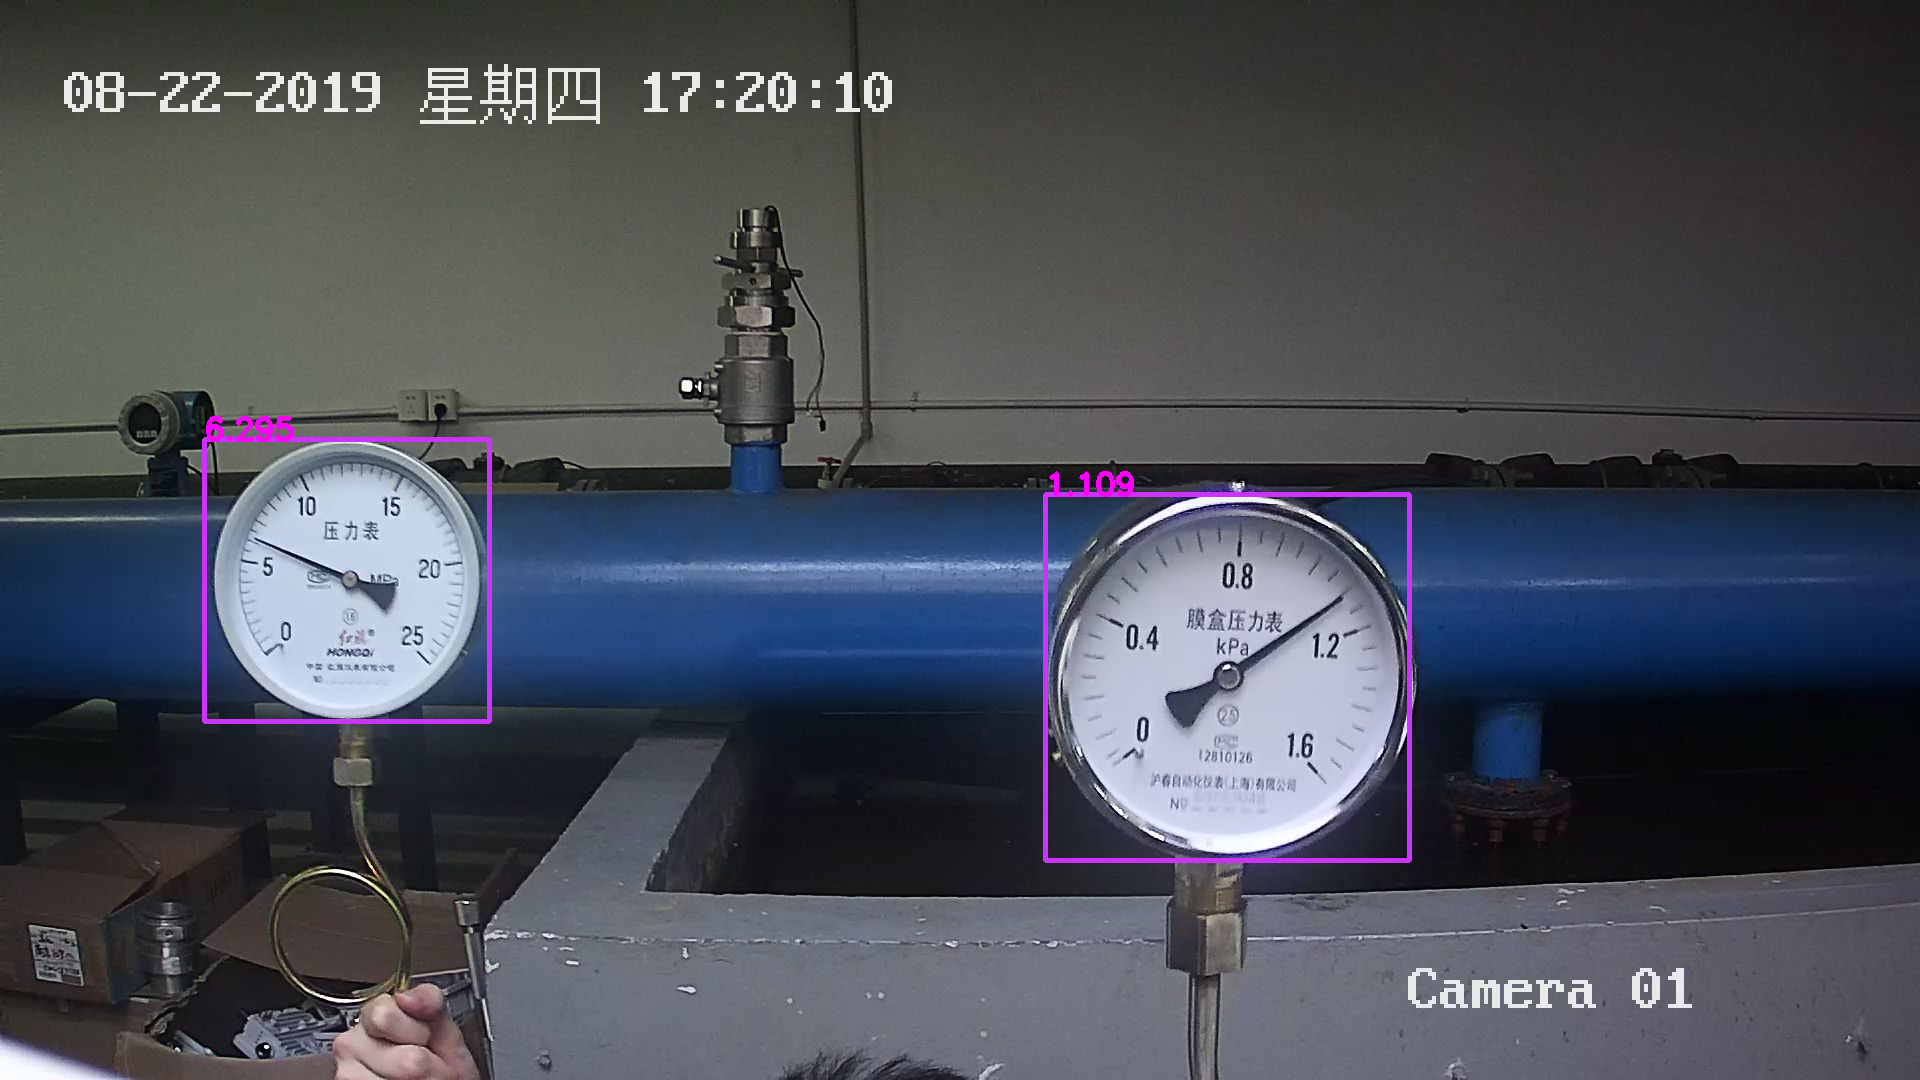

In [43]:
#Image / Still inference
test_img = cv2.imread('test.jpeg')
cv2_imshow(pipeline(test_img))

In [17]:
video = cv2.VideoCapture('hope2.mp4')
frame_width = int(video.get(3))
frame_height = int(video.get(4))
   
size = (frame_width, frame_height)
result = cv2.VideoWriter('result.avi', 
                         cv2.VideoWriter_fourcc(*'MJPG'),
                         10, size)

In [ ]:
while(video.isOpened()):
    ret, frame = video.read()
    if ret:
        plotted_frame = pipeline(frame)
        result.write(plotted_frame)
    else:
        break
video.release()
result.release()

In [ ]:
from google.colab import files
files.download('result.avi') 

## Testing OpenVINO compatibility of models

In [ ]:
!pip install openvino openvino-dev

In [21]:
from openvino.tools import mo
from openvino.runtime import serialize

In [ ]:
# exporting detector to openvino with ultralystics API
detector.export(format='openvino')

In [ ]:
#to convert HDF5 format we will first save TF model in `saved_model` format then use mo to convert
seg_path = path('segmentor_model')
seg_ir_path = path('segmentor_IR')
seg_path.mkdir(exist_ok=True)
seg_ir_path.mkdir(exist_ok=True)

tf.saved_model.save(segmentor,'segmentor_model')

model_ir = mo.convert_model(saved_model_dir=str(seg_path),input_shape=[-1,256,256,3])
serialize(model_ir,str(seg_ir_path / 'segmentor.xml'))

In [31]:
# benchmarking performance of detector and segmentor in openvino-IR format
!benchmark_app -m best_openvino_model/best.xml

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2022.3.0-9052-9752fafe8eb-releases/2022/3
[ INFO ] 
[ INFO ] Device info:
[ INFO ] CPU
[ INFO ] Build ................................. 2022.3.0-9052-9752fafe8eb-releases/2022/3
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(CPU) performance hint will be set to THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 84.05 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     images (node: images) : f32 / [...] / [1,3,512,512]
[ INFO ] Model outputs:
[ INFO ]     output0 (node: output0) : f32 / [...] / [1,5,5376]
[Step 5/11] Resizing model to match image sizes and given batch
[ INFO ] Model batch size: 1
[Step 6/11] Configuring input of the

In [39]:
!benchmark_app -m segmentor_IR/segmentor.xml -shape [5,256,256,3]

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2022.3.0-9052-9752fafe8eb-releases/2022/3
[ INFO ] 
[ INFO ] Device info:
[ INFO ] CPU
[ INFO ] Build ................................. 2022.3.0-9052-9752fafe8eb-releases/2022/3
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(CPU) performance hint will be set to THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 79.93 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     Func/StatefulPartitionedCall/input/_0:0 , data:0 , data (node: data) : f32 / [...] / [?,256,256,3]
[ INFO ] Model outputs:
[ INFO ]     Func/StatefulPartitionedCall/output/_309:0 , StatefulPartitionedCall/Identity:0 , StatefulPartitionedCall/model_1/softmax/Softmax:0 ,